# ECE 2595 Homework 1: Speech data classification for Parkinson's Disease patients
## Avery Peiffer

In [132]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [134]:
column_names_train = ['id', 'jitter_loc', 'jitter_loc_abs', 'jitter_rap', 'jitter_ppq5', 'jitter_ddp',
                      'shimmer_loc, shimmer_loc_db', 'shimmer_apq3', 'shimmer_apq5', 'shimmer_apq11', 'shimmer_dda',
                      'ac', 'nth', 'htn', 'med_pitch', 'mean_pitch', 'stdev_pitch', 'min_pitch', 'max_pitch',
                      'num_pulses', 'num_periods', 'mean_period', 'stdev_period', 'locally_unvoiced_frac', 'voice_breaks', 
                      'voice_break_deg', 'updrs', 'label']

column_names_test = column_names_train.copy()
column_names_test.remove('updrs')

train = pd.read_csv('./speech_data/train_data.txt', names=column_names_train)
test = pd.read_csv('./speech_data/test_data.txt', names=column_names_test)

print(train.head)

<bound method NDFrame.head of        id  jitter_loc  jitter_loc_abs  jitter_rap  jitter_ppq5  jitter_ddp  \
1   1.488    0.000090           0.900       0.794        2.699       8.334   
1   0.728    0.000038           0.353       0.376        1.059       5.864   
1   1.220    0.000074           0.732       0.670        2.196       8.719   
1   2.502    0.000123           1.156       1.634        3.469      13.513   
1   3.509    0.000167           1.715       1.539        5.145       9.112   
..    ...         ...             ...         ...          ...         ...   
40  5.127    0.000398           2.721       2.510        8.162       9.846   
40  1.757    0.000133           0.808       0.690        2.425       7.571   
40  2.912    0.000226           1.141       1.266        3.423      15.489   
40  3.788    0.000275           1.786       1.484        5.359      15.702   
40  1.809    0.000149           0.680       0.843        2.040       7.881   

    shimmer_loc, shimmer_loc_db  

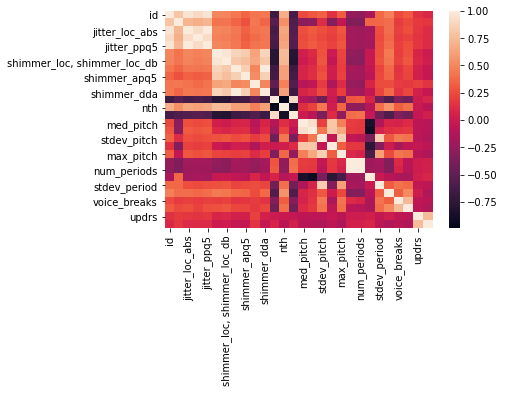

In [112]:
corr = train.corr()

ax = sns.heatmap(corr)

In [110]:
X_train_df = train.loc[:, ~train.columns.isin(['id', 'updrs', 'label'])]
X_train = X_train_df.to_numpy()
Y_train = train['label'].to_numpy()

X_test_df = test.loc[:, ~test.columns.isin(['id', 'label'])]
X_test = X_test_df.to_numpy()
Y_test = test['label'].to_numpy()

In [92]:
scaler = MinMaxScaler().fit(X_train)

X_train_t = scaler.transform(X_train)
X_test_t = scaler.transform(X_test)

### Logistic Regression

In [119]:
LogRegModel = LogisticRegression(solver='lbfgs', max_iter=1000, penalty='none')
LogRegModel.fit(X_train_t, Y_train)

print('Accuracy: %.2f' % LogRegModel.score(X_test_t, Y_test))

Accuracy: 0.07


Do 5-fold cross-validation to find the best regularization parameter for the Logistic Regression Model.

In [125]:
params = [0.01, 0.1, 1, 10, 100]

X_trainval = X_train
Y_trainval = Y_train
X_trainval_t = X_train_t

best_acc = 0
best_lambd = params[0]

for lambd in params:
    c = 1 / lambd
    LogRegModel = LogisticRegression(C=c, solver='lbfgs', max_iter=1000)
    scores = cross_val_score(LogRegModel, X_trainval_t, Y_trainval, cv=5)
    mean = scores.mean()
    
    if mean > best_acc:
        best_acc = mean
        best_lambd = lambd

print('Best tuning parameter is lambda = %.2f.' % best_lambd)
print('Trainval accuracy with this tuning parameter = %.2f.' % best_acc)

BestModel = LogisticRegression(C=1/best_lambd, solver='lbfgs', max_iter=1000)
BestModel.fit(X_trainval_t, Y_trainval)
print('Test accuracy with this tuning parameter = %.2f' % BestModel.score(X_test_t, Y_test))

Best tuning parameter is lambda = 1.00.
Trainval accuracy with this tuning parameter = 0.54.
Test accuracy with this tuning parameter = 0.11


### QDA

In [128]:
qda = QuadraticDiscriminantAnalysis()

qda.fit(X_train_t, Y_train)
qda_preds = qda.predict(X_test_t)

print('Accuracy is %.2f.' % accuracy_score(Y_test, qda_preds))
print(f'Precision is %.2f.' % precision_score(Y_test, qda_preds))
print(f'Recall is %.2f.' % recall_score(Y_test, qda_preds))

Accuracy is 0.83.
Precision is 1.00.
Recall is 0.83.


### AdaBoost

In [133]:
boostModel = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, random_state=0), 
                                n_estimators=5, random_state=0)
boostModel.fit(X_train_t, Y_train)

preds = boostModel.predict(X_test_t)
acc = np.count_nonzero(preds==Y_test) / len(preds)
print('Accuracy is %.4f.' % acc)

Accuracy is 0.1071.


### SVM

In [103]:
svmModel = SVC(kernel='rbf', gamma=0.2, C=0.1)
svmModel.fit(X_train_t, Y_train)

preds = svmModel.predict(X_test_t)
acc = svmModel.score(X_test_t, Y_test)

print('Accuracy is %.4f.' % accuracy_score(preds, Y_test))
print('Recall is %.4f.' % recall_score(preds, Y_test))
print('Precision is %.4f.' % precision_score(preds, Y_test))

Accuracy is 0.8274.
Recall is 1.0000.
Precision is 0.8274.
